In [ ]:
'''
                ***** LIME AND SHAP Explanation *****
                
This notebook provides the LIME and SHAP implementation for Regression based models (Boston HousePricing). 

A. LIME Explanation
B. SHAP Explanation

'''

In [14]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pickle
from sklearn.linear_model import LinearRegression
import shap
import pandas as pd

In [11]:
boston = load_boston()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80)

# Model is trainined using Random Forest based algorithm
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(train, labels_train)
filename = 'RandomForest.pkl'
pickle.dump(rf, open(filename, 'wb'))
random_forest_pickle = pickle.load(open('RandomForest.pkl', 'rb'))
rf_predicted = random_forest_pickle.predict(test)

'''
*** Model training using Linear Regression based algorithm ***

lm = LinearRegression()
lrmodel = lm.fit(train, labels_train)
with open('lr_model_pkl.pkl', 'wb') as fid:
    pickle.dump(lrmodel, fid)

with open('lr_model_pkl.pkl', 'rb') as fid:
    lr_model_import = pickle.load(fid)    

lr_predicted = lr_model_import.predict(test)
'''

In [7]:
'''
            **** LIME EXPLANATION ****
A. This Section provides Lime LimeTabularExplainer implementation
B. You can defined the num_feature attribute depends on for how many input features you would like to get explanation
   Max value of this attribute should be actual number of input features.

'''

categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()

#no need to mention class_name'labels in regression use case
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, categorical_features=categorical_features, mode='regression')

explanation_record_entries = []
for i in range(3): # for i in range(len(test))
    exp = explainer.explain_instance(test[i], random_forest_pickle.predict, num_features=5)
    lim = {
        "trueClass": labels_test[i],
        "predictedClass": rf_predicted[i],
        "explanation":  exp.as_list()
    }
    explanation_record_entries.append(lim)

explanation_record_entries

[{'trueClass': 18.7,
  'predictedClass': 19.1606,
  'explanation': [('RM <= 5.89', -4.388392237756506),
   ('DIS > 5.40', -0.9704594535423174),
   ('11.04 < LSTAT <= 16.31', -0.7844610913656047),
   ('277.00 < TAX <= 322.00', -0.5981090511782866),
   ('42.05 < AGE <= 74.60', 0.47574488262526254)]},
 {'trueClass': 16.1,
  'predictedClass': 16.007200000000047,
  'explanation': [('LSTAT > 16.31', -5.214855730202313),
   ('6.18 < RM <= 6.64', -2.1571013474471536),
   ('NOX > 0.62', -0.7292633733245254),
   ('322.00 < TAX <= 666.00', -0.5945608683825083),
   ('18.90 < PTRATIO <= 20.20', -0.531733503594978)]},
 {'trueClass': 17.8,
  'predictedClass': 13.819400000000007,
  'explanation': [('LSTAT > 16.31', -5.169426320746057),
   ('RM <= 5.89', -4.506162660280874),
   ('DIS <= 2.17', 1.4132647822584523),
   ('NOX > 0.62', -1.0985526122850804),
   ('PTRATIO <= 17.00', 0.634351745143907)]}]

In [15]:
'''
            **** SHAP EXPLANATION ****
A. This Section provides SHAP  implementation

'''

algorithm = 'randomForest'
if algorithm in ['linearRegression', 'logisticRegression', 'naivebayes', 'svm']:
    explainer = shap.LinearExplainer(random_forest_pickle, train, feature_dependence="independent")
elif algorithm in ['decisionTree', 'randomForest', 'gradientBoosting']:
    explainer = shap.TreeExplainer(random_forest_pickle)

shap_values = explainer.shap_values(test)
shap_sum = np.abs(shap_values).mean(axis=0)


feature_names=boston.feature_names

importance_df = pd.DataFrame([feature_names, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df = importance_df[importance_df['shap_importance'] > 0.10]
importance_df.head()

[0.36327886 0.01014925 0.09304091 0.01263563 0.43474591 4.3535575
 0.27577363 0.39605205 0.05388841 0.18566311 0.32287719 0.12229238
 3.22301472]
*************


,column_name,shap_importance
5,RM,4.35356
12,LSTAT,3.22301
4,NOX,0.434746
7,DIS,0.396052
0,CRIM,0.363279


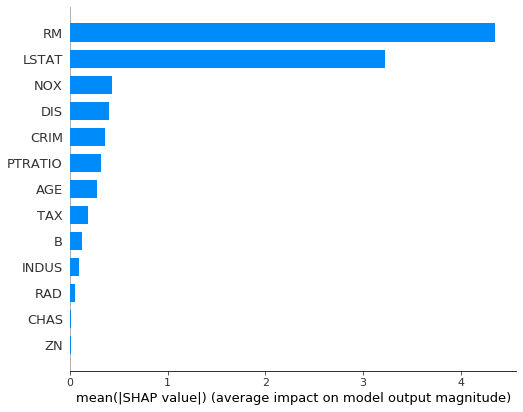

In [17]:
shap.summary_plot(shap_values, test, feature_names=boston.feature_names, plot_type="bar")